### File Discovery

* ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/

This notebook is for finding a list of relavent  elevation files for New Orleans, using the metatdata supplied

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import matplotlib.pyplot as plt
from os import listdir
from os.path import exists
from shapely.geometry import Point, Polygon

import xml.etree.ElementTree as et

In [2]:
epsg = 4289

newOrleansBounds = {}
newOrleansBounds['north'] = 30.16
newOrleansBounds['south'] = 29.89
newOrleansBounds['west'] = -90.145
newOrleansBounds['east'] = -89.769

metatDataPath = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/metadata/'
shapeFilePath = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/'

neighborhoodDf = gpd.read_file('zip://./NewOrleansShapeFiles/Neighborhood_Statistical_Areas.zip!Neighborhood_Statistical_Areas.shp').to_crs(epsg=epsg)
waterDf = gpd.read_file('zip://./NewOrleansShapeFiles/water.zip!WATER2.SHP')

In [3]:
def getBounds(name, elem):
    return float(elem.find(name).text)

def metaDataInBounds(xmlFileName, debug=False, bounds = newOrleansBounds, forceXmlBounds = False):
    tree = et.parse(xmlFileName)
    treeRoot = tree.getroot()
    idinfoElem = treeRoot.find('idinfo')
    spdomElem = idinfoElem.find('spdom')
    boundsElem = spdomElem.find('bounding')
    
    fileElem = treeRoot
    targetPath = ['distinfo','stdorder', 'digform', 'digtopt', 'onlinopt', 'computer','networka','networkr']
    for target in targetPath:
        if debug:
            print("targetPath: ", fileElem.tag)
            
        fileElem = fileElem.find(target)
        
    ftpFileName = fileElem.text
    
    
    if forceXmlBounds:
        (northbc,southbc,eastbc,westbc) = forceXmlBounds
    else:
        (northbc,southbc,eastbc,westbc) = (getBounds(name, boundsElem) for name in ['northbc','southbc','eastbc','westbc']  )
    
    overLap = True
    eastOverLap = True
    northOverLap = True
    #xml is east or west of bounds
    if eastbc < bounds['west'] or westbc > bounds['east'] :
        overLap = False
        eastOverLap = False
        
    #xml is north or south  bounds
    if southbc > bounds['north'] or northbc < bounds['south']:
        overLap = False
        northOverLap = False
        
    if debug:
        print(northbc,southbc,eastbc,westbc)
        print("New Orleans bounds: ", bounds)
        print("OverLapped: ", overLap)
        print("FTP Filename: ", ftpFileName)
        
    return {
                'filename': xmlFileName.split('/')[-1],
                'overLap': overLap,
                'eastOverLap': eastOverLap,
                'northOverLap': northOverLap,
                'northbc': northbc,
                'southbc': southbc,
                'eastbc': eastbc,
                'westbc': westbc,
                'ftpFileName': ftpFileName
            }


In [4]:
xmlFiles = pd.DataFrame( [metatDataPath + name for name in listdir('./USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/metadata/') if name[-4:] == '.xml'], columns=['filename'] )
xmlFiles = pd.DataFrame( xmlFiles['filename'].apply(metaDataInBounds).to_list() )

In [5]:
xmlFiles[xmlFiles['overLap']].head()

,filename,overLap,eastOverLap,northOverLap,northbc,southbc,eastbc,westbc,ftpFileName
4,USGS_LPC_LA_UpperDeltaPlain_2017_15ryp995270_L...,True,True,True,30.050959,30.037075,-89.878328,-89.894287,ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/...
12,USGS_LPC_LA_UpperDeltaPlain_2017_15ryp860255_L...,True,True,True,30.040672,30.026802,-90.018579,-90.034520,ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/...
15,USGS_LPC_LA_UpperDeltaPlain_2017_15ryp755240_L...,True,True,True,30.026428,30.015704,-90.127830,-90.143665,ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/...
23,USGS_LPC_LA_UpperDeltaPlain_2017_15ryp770165_L...,True,True,True,29.961624,29.947765,-90.114160,-90.130075,ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/...
28,USGS_LPC_LA_UpperDeltaPlain_2017_15ryp950330_L...,True,True,True,30.100587,30.092242,-89.923432,-89.930972,ftp://rockyftp.cr.usgs.gov/vdelivery/Datasets/...


In [6]:
xmlFiles.count()

filename        4802
overLap         4802
eastOverLap     4802
northOverLap    4802
northbc         4802
southbc         4802
eastbc          4802
westbc          4802
ftpFileName     4802
dtype: int64

In [7]:
#this is what needs to be downloaded
np.count_nonzero(xmlFiles['overLap'])

292

<AxesSubplot:>

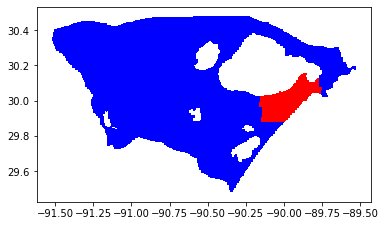

In [8]:
fig, ax = plt.subplots()

polygons = []
for row in xmlFiles.iterrows():
    data = row[1]
    polygons.append(Polygon((
        (data['westbc'],data['northbc']),
        (data['eastbc'],data['northbc']),
        (data['eastbc'],data['southbc']),
        (data['westbc'],data['southbc']),
    )))
    
xmlFilesGeo = gpd.GeoDataFrame(xmlFiles, geometry=polygons).set_crs(epsg)
xmlFilesGeo.plot(facecolor='blue',ax=ax)
xmlFilesGeo[xmlFilesGeo['overLap']].plot(facecolor='red',ax=ax)

In [ ]:
projection = gplt.Mercator()
fig, ax = plt.subplots(figsize=(28,18), subplot_kw={'projection': projection})

extent = (-90.14003111,  29.86560481, -89.87, 30.08)
extent = (newOrleansBounds['west'], newOrleansBounds['south'], newOrleansBounds['east'], newOrleansBounds['north'])

gplt.polyplot(xmlFilesGeo[xmlFilesGeo['overLap']], ax=ax, facecolor='red', projection=projection)   
gplt.polyplot(neighborhoodDf, edgecolor='black', projection=projection, ax=ax)
gplt.polyplot(waterDf,ax=ax, projection=projection, edgecolor='#abd3df', facecolor='#abd3df')


fig.tight_layout()

In [13]:
xmlFilesGeo.to_pickle('./xmlFilesGeo.pickle')

In [14]:
!ls xmlFilesGeo.pickle

xmlFilesGeo.pickle


In [20]:
#this will be used

files = xmlFilesGeo[xmlFilesGeo['overLap']]['ftpFileName'].to_list()
with open('fileList.txt', 'w') as f:
    for file in files:
        f.write(file + "\n")
    

## Dont forget to unzip everything